In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
import itertools
import pickle, gzip
import glob
import importlib
import time

from cv_sampler import *

np.warnings.filterwarnings('ignore')


In [2]:
import load_data
importlib.reload(load_data)

<module 'load_data' from '/home/matsui-k/projects/kaggle-lsst/scripts/load_data.py'>

In [3]:
gal_df, ex_df, gal_target, ex_target = load_data.load_train()

In [4]:
del gal_df, gal_target

In [5]:
gal_class_weight, gal_sample_weights, gal_target_i = load_data.get_weights(ex_target)

In [8]:
gal_class_weight

{0: 2, 1: 1, 2: 1, 3: 1, 4: 2, 5: 1, 6: 1, 7: 1, 8: 1}

In [11]:
gal_df=ex_df

0 Sat Dec  8 10:55:24 2018
1 Sat Dec  8 10:55:33 2018
2 Sat Dec  8 10:56:20 2018
3 Sat Dec  8 10:56:41 2018
4 Sat Dec  8 10:56:51 2018
5 Sat Dec  8 10:57:10 2018
6 Sat Dec  8 10:57:20 2018
7 Sat Dec  8 10:57:56 2018
8 Sat Dec  8 10:58:30 2018
9 Sat Dec  8 10:59:06 2018
10 Sat Dec  8 10:59:11 2018
11 Sat Dec  8 10:59:25 2018
12 Sat Dec  8 10:59:32 2018
13 Sat Dec  8 11:00:12 2018
14 Sat Dec  8 11:00:19 2018
15 Sat Dec  8 11:00:52 2018
16 Sat Dec  8 11:01:36 2018
17 Sat Dec  8 11:01:49 2018
18 Sat Dec  8 11:02:07 2018
19 Sat Dec  8 11:02:18 2018
20 Sat Dec  8 11:02:59 2018
21 Sat Dec  8 11:03:07 2018
22 Sat Dec  8 11:03:34 2018
23 Sat Dec  8 11:04:01 2018
24 Sat Dec  8 11:04:43 2018
25 Sat Dec  8 11:04:59 2018
26 Sat Dec  8 11:05:46 2018
27 Sat Dec  8 11:05:54 2018
28 Sat Dec  8 11:06:10 2018
29 Sat Dec  8 11:06:47 2018
30 Sat Dec  8 11:07:10 2018
31 Sat Dec  8 11:07:25 2018
32 Sat Dec  8 11:08:10 2018
33 Sat Dec  8 11:09:27 2018
34 Sat Dec  8 11:09:37 2018
35 Sat Dec  8 11:09:49 2018
36

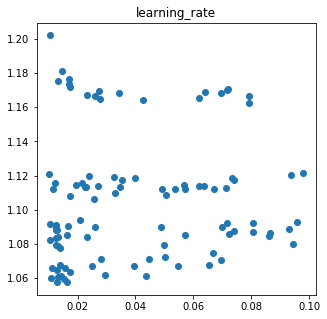

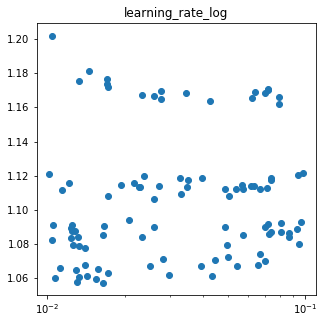

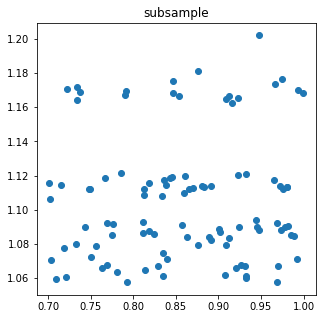

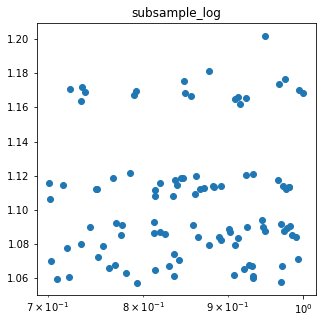

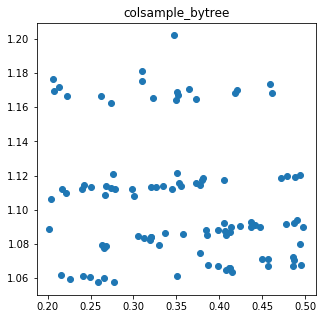

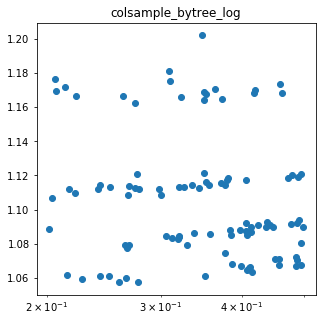

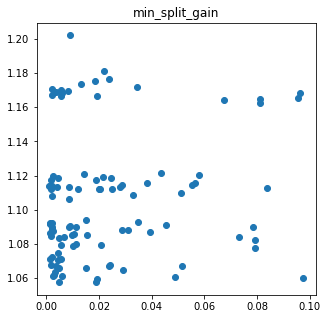

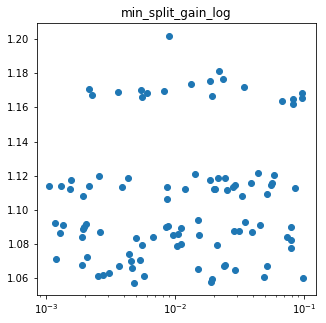

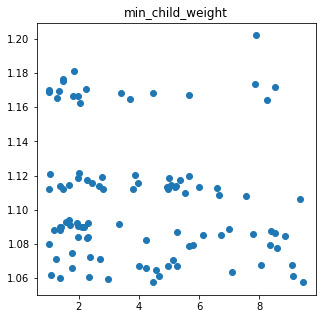

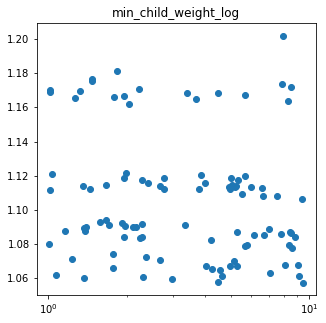

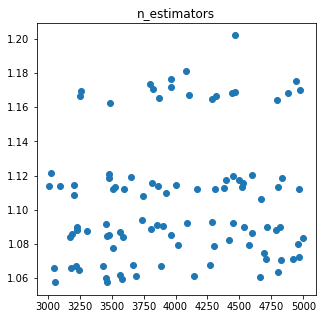

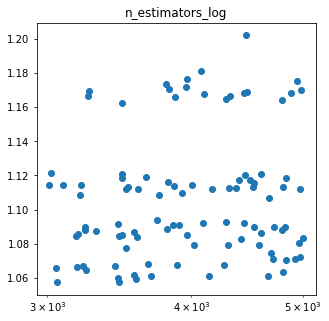

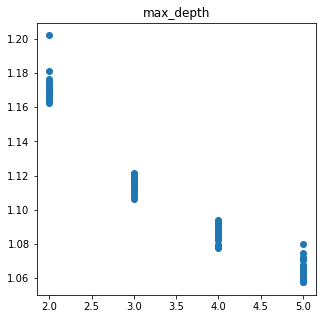

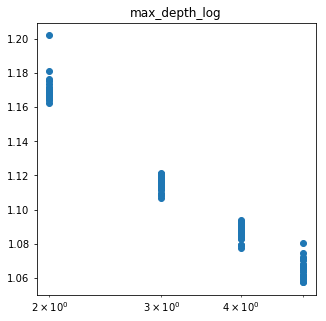

In [12]:
param_samplers = {
    'learning_rate': LogUniformSampler(-2, -1),
    'subsample': UniformSampler(0.7, 1),
    'colsample_bytree': UniformSampler(0.2, 0.5),
    'min_split_gain': LogUniformSampler(-3, -1),
    'min_child_weight': LogUniformSampler(0, 1),
    'n_estimators': UniformSampler(3000, 5000, int),
    'max_depth': UniformSampler(2, 6, int)
}
 
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
param_list = []
score_list = []
n_seed = 100
for i_seed in range(n_seed):
    print(i_seed, time.ctime())
    gal_clfs = []
    gal_importances = pd.DataFrame()
    gal_lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 9,
        'metric': 'multi_logloss',
        'class_weight': gal_class_weight,
        'learning_rate': param_samplers['learning_rate'].rvs(),
        'subsample': param_samplers['subsample'].rvs(),
        'colsample_bytree': param_samplers['colsample_bytree'].rvs(),
        'min_split_gain': param_samplers['min_split_gain'].rvs(),
        'min_child_weight': param_samplers['min_child_weight'].rvs(),
        'n_estimators': param_samplers['n_estimators'].rvs(),
        'max_depth': param_samplers['max_depth'].rvs(),
        'silent': True
    }
    
    param_list.append(gal_lgb_params)
    
    seed_score_list = []
    for i_fold, (trn_index, val_index) in enumerate(folds.split(gal_target_i, gal_target_i)):
        trn_x, trn_y = gal_df.iloc[trn_index], gal_target_i.iloc[trn_index]
        val_x, val_y = gal_df.iloc[val_index], gal_target_i.iloc[val_index]

        gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
        gal_clf.fit(
            trn_x, trn_y,
            sample_weight=trn_y.map(gal_sample_weights),
            eval_set=[(val_x, val_y)],
            eval_metric='multi_logloss',
            eval_class_weight=[gal_class_weight],
            verbose=False,
            early_stopping_rounds=50
        )

        imp_df = pd.DataFrame()
        imp_df['feature'] = gal_df.columns
        imp_df['gain'] = gal_clf.feature_importances_
        imp_df['fold'] = i_fold + 1
        gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)

        gal_clfs.append(gal_clf)
        
        seed_score_list.append(gal_clf.best_score_['valid_0']['multi_logloss'])
    score_list.append(np.mean(seed_score_list))


param_keys = ['learning_rate',
  'subsample',
  'colsample_bytree',
  'min_split_gain',
  'min_child_weight',
  'n_estimators',
  'max_depth']

for param_key in param_keys:
    values = [ param_dict[param_key] for param_dict in param_list]
    plt.figure(figsize=(5, 5))
    plt.title(param_key)
    plt.plot(values, score_list, 'o')
    plt.figure(figsize=(5, 5))
    plt.title(param_key+'_log')
    plt.plot(values, score_list, 'o')
    plt.xscale('log')

0 Sat Dec  8 11:42:14 2018
1 Sat Dec  8 11:42:39 2018
2 Sat Dec  8 11:43:13 2018
3 Sat Dec  8 11:43:22 2018
4 Sat Dec  8 11:44:03 2018
5 Sat Dec  8 11:44:30 2018
6 Sat Dec  8 11:44:46 2018
7 Sat Dec  8 11:45:31 2018
8 Sat Dec  8 11:45:44 2018
9 Sat Dec  8 11:46:51 2018
10 Sat Dec  8 11:47:26 2018
11 Sat Dec  8 11:48:02 2018
12 Sat Dec  8 11:48:21 2018
13 Sat Dec  8 11:48:54 2018
14 Sat Dec  8 11:49:22 2018
15 Sat Dec  8 11:49:39 2018
16 Sat Dec  8 11:50:21 2018
17 Sat Dec  8 11:50:58 2018
18 Sat Dec  8 11:51:37 2018
19 Sat Dec  8 11:53:04 2018
20 Sat Dec  8 11:53:40 2018
21 Sat Dec  8 11:54:06 2018
22 Sat Dec  8 11:55:18 2018
23 Sat Dec  8 11:55:38 2018
24 Sat Dec  8 11:55:47 2018
25 Sat Dec  8 11:55:59 2018
26 Sat Dec  8 11:57:01 2018
27 Sat Dec  8 11:57:16 2018
28 Sat Dec  8 11:57:25 2018
29 Sat Dec  8 11:58:12 2018
30 Sat Dec  8 11:58:26 2018
31 Sat Dec  8 11:58:46 2018
32 Sat Dec  8 11:59:13 2018
33 Sat Dec  8 11:59:42 2018
34 Sat Dec  8 12:00:27 2018
35 Sat Dec  8 12:00:39 2018
36

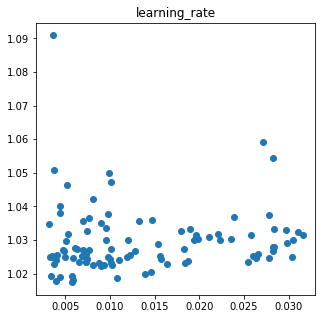

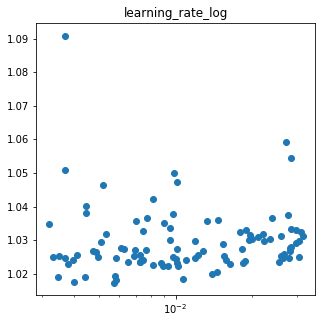

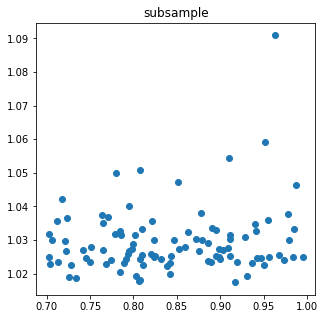

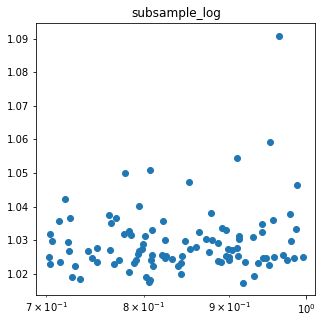

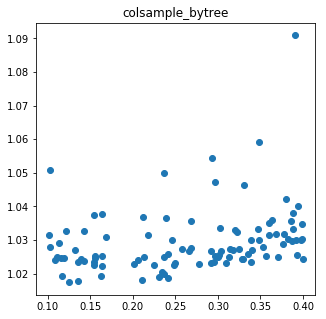

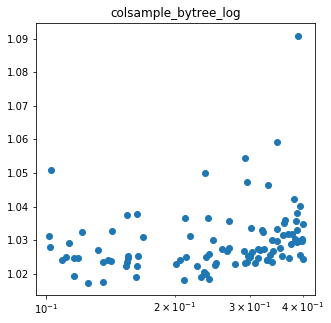

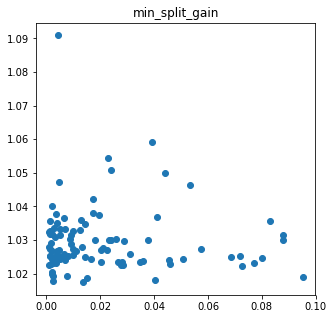

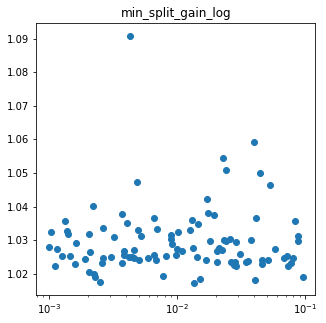

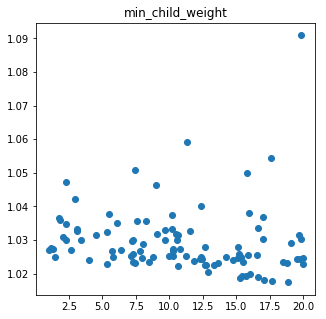

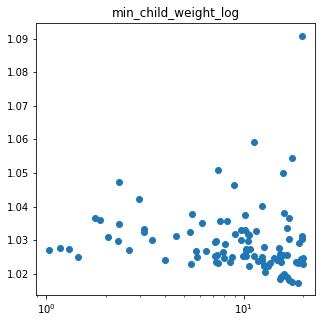

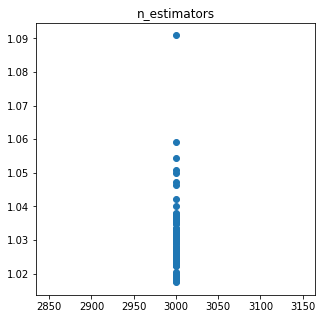

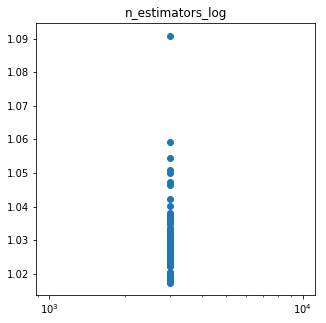

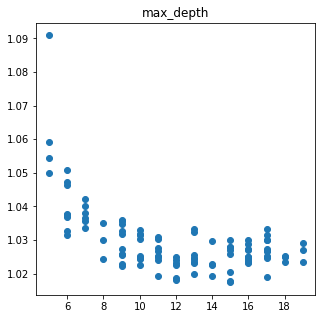

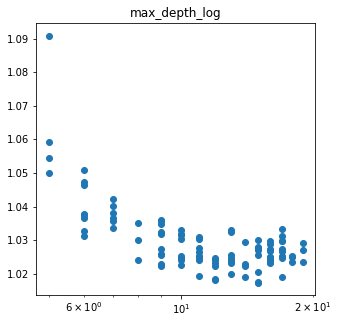

In [13]:
param_samplers = {
    'learning_rate': LogUniformSampler(-2.5, -1.5),
    'subsample': UniformSampler(0.7, 1),
    'colsample_bytree': UniformSampler(0.1, 0.4),
    'min_split_gain': LogUniformSampler(-3, -1),
    'min_child_weight': UniformSampler(1, 20),
    'n_estimators': UniformSampler(3000, 3001, int),
    'max_depth': UniformSampler(5, 20, int)
}
 
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
param_list = []
score_list = []
n_seed = 100
for i_seed in range(n_seed):
    print(i_seed, time.ctime())
    gal_clfs = []
    gal_importances = pd.DataFrame()
    gal_lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 9,
        'metric': 'multi_logloss',
        'class_weight': gal_class_weight,
        'learning_rate': param_samplers['learning_rate'].rvs(),
        'subsample': param_samplers['subsample'].rvs(),
        'colsample_bytree': param_samplers['colsample_bytree'].rvs(),
        'min_split_gain': param_samplers['min_split_gain'].rvs(),
        'min_child_weight': param_samplers['min_child_weight'].rvs(),
        'n_estimators': param_samplers['n_estimators'].rvs(),
        'max_depth': param_samplers['max_depth'].rvs(),
        'silent': True,
        'n_jobs': 8
    }
    
    param_list.append(gal_lgb_params)
    
    seed_score_list = []
    for i_fold, (trn_index, val_index) in enumerate(folds.split(gal_target_i, gal_target_i)):
        trn_x, trn_y = gal_df.iloc[trn_index], gal_target_i.iloc[trn_index]
        val_x, val_y = gal_df.iloc[val_index], gal_target_i.iloc[val_index]

        gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
        gal_clf.fit(
            trn_x, trn_y,
            sample_weight=trn_y.map(gal_sample_weights),
            eval_set=[(val_x, val_y)],
            eval_metric='multi_logloss',
            eval_class_weight=[gal_class_weight],
            verbose=False,
            early_stopping_rounds=50
        )

        imp_df = pd.DataFrame()
        imp_df['feature'] = gal_df.columns
        imp_df['gain'] = gal_clf.feature_importances_
        imp_df['fold'] = i_fold + 1
        gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)

        gal_clfs.append(gal_clf)
        
        seed_score_list.append(gal_clf.best_score_['valid_0']['multi_logloss'])
    score_list.append(np.mean(seed_score_list))


param_keys = ['learning_rate',
  'subsample',
  'colsample_bytree',
  'min_split_gain',
  'min_child_weight',
  'n_estimators',
  'max_depth']

for param_key in param_keys:
    values = [ param_dict[param_key] for param_dict in param_list]
    plt.figure(figsize=(5, 5))
    plt.title(param_key)
    plt.plot(values, score_list, 'o')
    plt.figure(figsize=(5, 5))
    plt.title(param_key+'_log')
    plt.plot(values, score_list, 'o')
    plt.xscale('log')

0 Sat Dec  8 12:57:15 2018
1 Sat Dec  8 12:58:08 2018
2 Sat Dec  8 12:59:19 2018
3 Sat Dec  8 13:00:39 2018
4 Sat Dec  8 13:01:47 2018
5 Sat Dec  8 13:02:49 2018
6 Sat Dec  8 13:03:20 2018
7 Sat Dec  8 13:04:30 2018
8 Sat Dec  8 13:05:28 2018
9 Sat Dec  8 13:06:23 2018
10 Sat Dec  8 13:07:01 2018
11 Sat Dec  8 13:07:44 2018
12 Sat Dec  8 13:09:03 2018
13 Sat Dec  8 13:10:15 2018
14 Sat Dec  8 13:11:15 2018
15 Sat Dec  8 13:12:13 2018
16 Sat Dec  8 13:13:24 2018
17 Sat Dec  8 13:14:11 2018
18 Sat Dec  8 13:14:36 2018
19 Sat Dec  8 13:15:45 2018
20 Sat Dec  8 13:16:57 2018
21 Sat Dec  8 13:17:58 2018
22 Sat Dec  8 13:18:36 2018
23 Sat Dec  8 13:19:39 2018
24 Sat Dec  8 13:20:57 2018
25 Sat Dec  8 13:22:12 2018
26 Sat Dec  8 13:23:30 2018
27 Sat Dec  8 13:24:36 2018
28 Sat Dec  8 13:25:07 2018
29 Sat Dec  8 13:26:12 2018
30 Sat Dec  8 13:26:48 2018
31 Sat Dec  8 13:27:49 2018
32 Sat Dec  8 13:28:58 2018
33 Sat Dec  8 13:29:34 2018
34 Sat Dec  8 13:30:42 2018
35 Sat Dec  8 13:31:14 2018
36

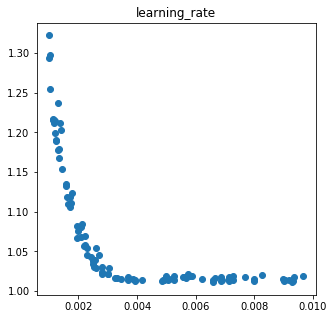

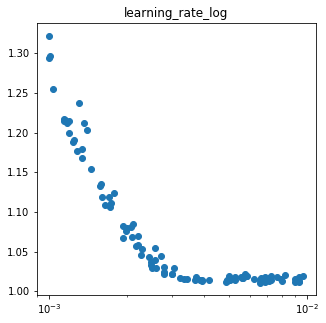

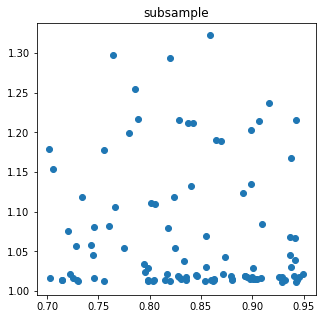

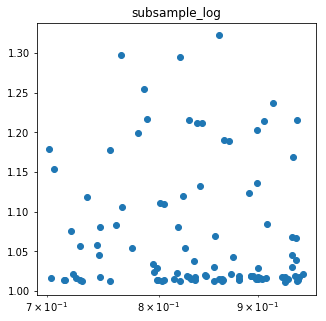

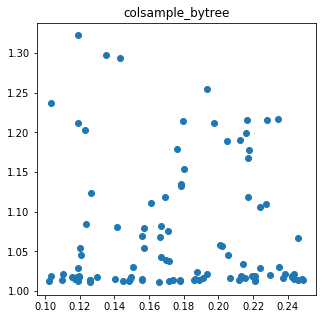

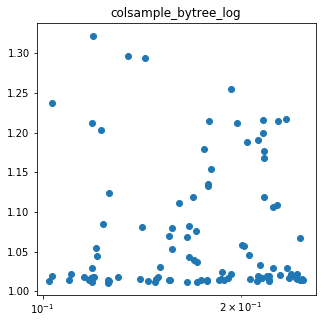

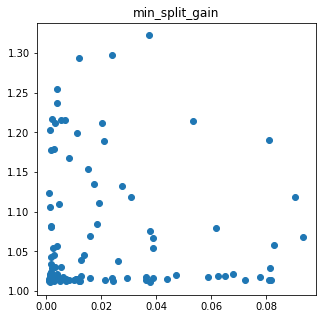

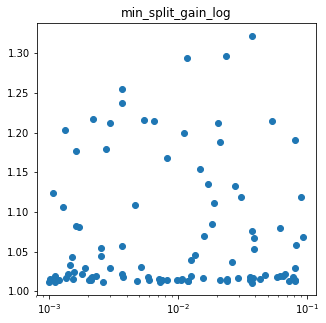

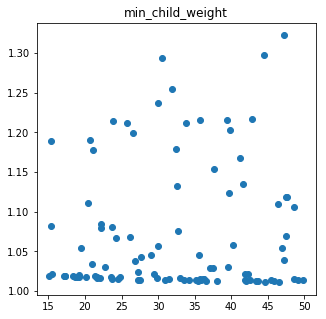

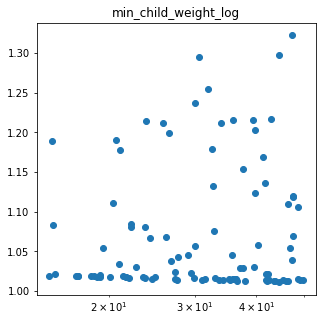

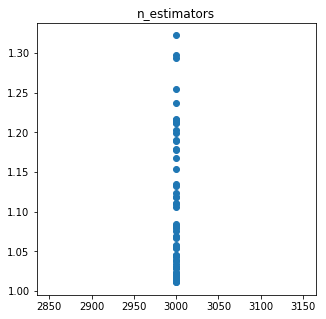

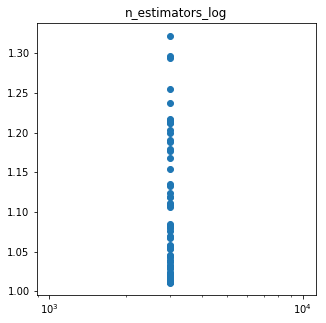

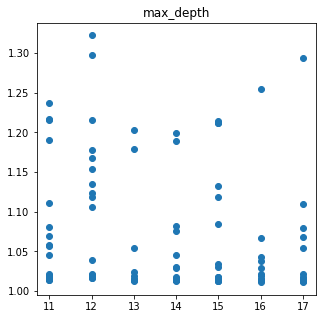

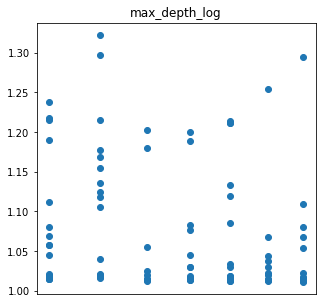

In [14]:
param_samplers = {
    'learning_rate': LogUniformSampler(-3, -2),
    'subsample': UniformSampler(0.7, 0.95),
    'colsample_bytree': UniformSampler(0.1, 0.25),
    'min_split_gain': LogUniformSampler(-3, -1),
    'min_child_weight': UniformSampler(15, 50),
    'n_estimators': UniformSampler(3000, 3001, int),
    'max_depth': UniformSampler(11, 18, int)
}
 
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
param_list = []
score_list = []
n_seed = 100
for i_seed in range(n_seed):
    print(i_seed, time.ctime())
    gal_clfs = []
    gal_importances = pd.DataFrame()
    gal_lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 9,
        'metric': 'multi_logloss',
        'class_weight': gal_class_weight,
        'learning_rate': param_samplers['learning_rate'].rvs(),
        'subsample': param_samplers['subsample'].rvs(),
        'colsample_bytree': param_samplers['colsample_bytree'].rvs(),
        'min_split_gain': param_samplers['min_split_gain'].rvs(),
        'min_child_weight': param_samplers['min_child_weight'].rvs(),
        'n_estimators': param_samplers['n_estimators'].rvs(),
        'max_depth': param_samplers['max_depth'].rvs(),
        'silent': True,
        'n_jobs': 8
    }
    
    param_list.append(gal_lgb_params)
    
    seed_score_list = []
    for i_fold, (trn_index, val_index) in enumerate(folds.split(gal_target_i, gal_target_i)):
        trn_x, trn_y = gal_df.iloc[trn_index], gal_target_i.iloc[trn_index]
        val_x, val_y = gal_df.iloc[val_index], gal_target_i.iloc[val_index]

        gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
        gal_clf.fit(
            trn_x, trn_y,
            sample_weight=trn_y.map(gal_sample_weights),
            eval_set=[(val_x, val_y)],
            eval_metric='multi_logloss',
            eval_class_weight=[gal_class_weight],
            verbose=False,
            early_stopping_rounds=50
        )

        imp_df = pd.DataFrame()
        imp_df['feature'] = gal_df.columns
        imp_df['gain'] = gal_clf.feature_importances_
        imp_df['fold'] = i_fold + 1
        gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)

        gal_clfs.append(gal_clf)
        
        seed_score_list.append(gal_clf.best_score_['valid_0']['multi_logloss'])
    score_list.append(np.mean(seed_score_list))


param_keys = ['learning_rate',
  'subsample',
  'colsample_bytree',
  'min_split_gain',
  'min_child_weight',
  'n_estimators',
  'max_depth']

for param_key in param_keys:
    values = [ param_dict[param_key] for param_dict in param_list]
    plt.figure(figsize=(5, 5))
    plt.title(param_key)
    plt.plot(values, score_list, 'o')
    plt.figure(figsize=(5, 5))
    plt.title(param_key+'_log')
    plt.plot(values, score_list, 'o')
    plt.xscale('log')

In [17]:
gal_importances = pd.DataFrame()
gal_lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 9,
    'metric': 'multi_logloss',
    'class_weight': gal_class_weight,
    'learning_rate': 0.004,
    'subsample': 0.7,
    'colsample_bytree': 0.1,
    'min_split_gain': 0.01,
    'min_child_weight': 50,
    'n_estimators': 3000,
    'max_depth': 13,
    'silent': False,
    'n_jobs': 2
}

folds = StratifiedKFold(n_splits=, shuffle=True, random_state=1)
param_list = []
score_list = []
for i_fold, (trn_index, val_index) in enumerate(folds.split(gal_target_i, gal_target_i)):
    trn_x, trn_y = gal_df.iloc[trn_index], gal_target_i.iloc[trn_index]
    val_x, val_y = gal_df.iloc[val_index], gal_target_i.iloc[val_index]

    gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
    gal_clf.fit(
        trn_x, trn_y,
        sample_weight=trn_y.map(gal_sample_weights),
        eval_set=[(val_x, val_y)],
        eval_metric='multi_logloss',
        eval_class_weight=[gal_class_weight],
        verbose=100,
        early_stopping_rounds=50
    )
    
    print(gal_clf.best_iteration_)

    imp_df = pd.DataFrame()
    imp_df['feature'] = gal_df.columns
    imp_df['gain'] = gal_clf.feature_importances_
    gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)


Training until validation scores don't improve for 50 rounds.
[100]	valid_0's multi_logloss: 1.94763
[200]	valid_0's multi_logloss: 1.7872
[300]	valid_0's multi_logloss: 1.66729
[400]	valid_0's multi_logloss: 1.57443
[500]	valid_0's multi_logloss: 1.49668
[600]	valid_0's multi_logloss: 1.43156
[700]	valid_0's multi_logloss: 1.37752
[800]	valid_0's multi_logloss: 1.32974
[900]	valid_0's multi_logloss: 1.28798
[1000]	valid_0's multi_logloss: 1.25114
[1100]	valid_0's multi_logloss: 1.21885
[1200]	valid_0's multi_logloss: 1.19031
[1300]	valid_0's multi_logloss: 1.16478
[1400]	valid_0's multi_logloss: 1.14277
[1500]	valid_0's multi_logloss: 1.12315
[1600]	valid_0's multi_logloss: 1.10621
[1700]	valid_0's multi_logloss: 1.09136
[1800]	valid_0's multi_logloss: 1.0787
[1900]	valid_0's multi_logloss: 1.06752
[2000]	valid_0's multi_logloss: 1.05799
[2100]	valid_0's multi_logloss: 1.04954
[2200]	valid_0's multi_logloss: 1.04205
[2300]	valid_0's multi_logloss: 1.0358
[2400]	valid_0's multi_logloss

In [19]:
gal_importances = pd.DataFrame()
gal_lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 9,
    'metric': 'multi_logloss',
    'class_weight': gal_class_weight,
    'learning_rate': 0.004,
    'subsample': 0.7,
    'colsample_bytree': 0.1,
    'min_split_gain': 0.01,
    'min_child_weight': 50,
    'n_estimators': 3000,
    'max_depth': 13,
    'silent': False,
    'n_jobs': -1,
    'num_iterations':3000
}

trn_x = gal_df
trn_y = gal_target_i
param_list = []
score_list = []
gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
gal_clf.fit(
    trn_x, trn_y,
    sample_weight=trn_y.map(gal_sample_weights),
    eval_set=[(trn_x, trn_y)],
    eval_metric='multi_logloss',
    eval_class_weight=[gal_class_weight],
    verbose=100
)

print(gal_clf.best_iteration_)

imp_df = pd.DataFrame()
imp_df['feature'] = gal_df.columns
imp_df['gain'] = gal_clf.feature_importances_
gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)


[100]	training's multi_logloss: 1.69757
[200]	training's multi_logloss: 1.39917
[300]	training's multi_logloss: 1.18843
[400]	training's multi_logloss: 1.03112
[500]	training's multi_logloss: 0.906441
[600]	training's multi_logloss: 0.806239
[700]	training's multi_logloss: 0.724133
[800]	training's multi_logloss: 0.655277
[900]	training's multi_logloss: 0.596397
[1000]	training's multi_logloss: 0.545356
[1100]	training's multi_logloss: 0.501092
[1200]	training's multi_logloss: 0.462255
[1300]	training's multi_logloss: 0.427966
[1400]	training's multi_logloss: 0.397679
[1500]	training's multi_logloss: 0.370312
[1600]	training's multi_logloss: 0.34591
[1700]	training's multi_logloss: 0.323854
[1800]	training's multi_logloss: 0.303935
[1900]	training's multi_logloss: 0.285762
[2000]	training's multi_logloss: 0.26924
[2100]	training's multi_logloss: 0.254137
[2200]	training's multi_logloss: 0.240201
[2300]	training's multi_logloss: 0.227381
[2400]	training's multi_logloss: 0.215655
[2500]	

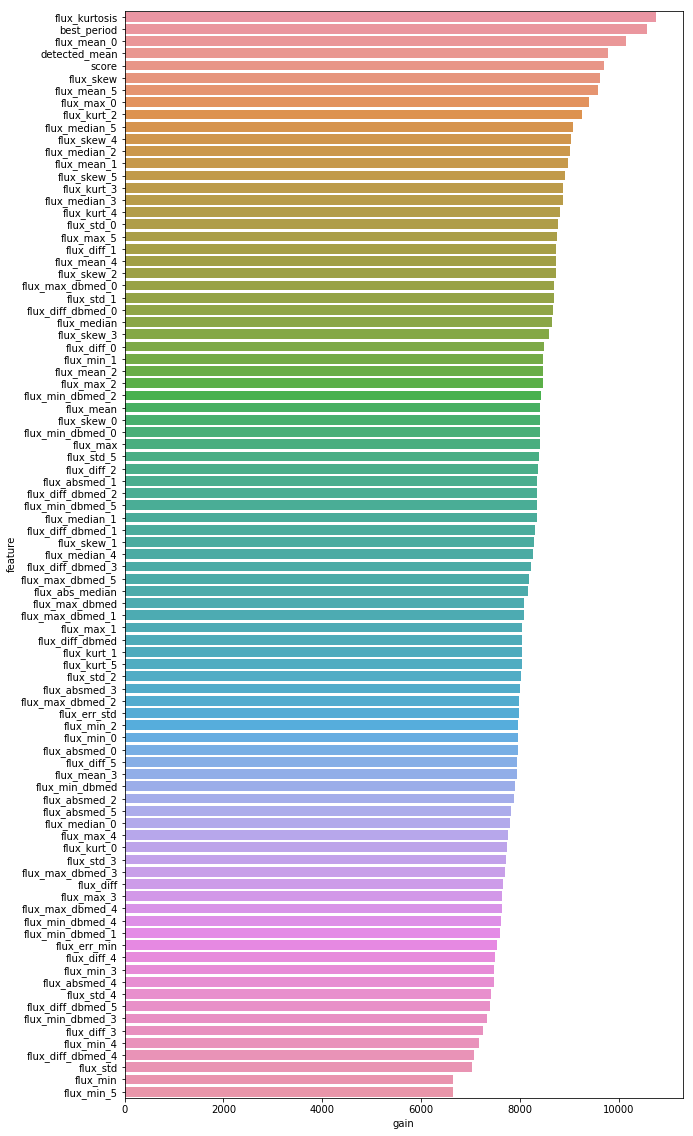

In [20]:
plt.figure(figsize=(10, 20))
sns.barplot(x='gain', y='feature', data=gal_importances.sort_values('gain', ascending=False))

In [22]:

from joblib import dump, load

dump(gal_clf, '../models/ex_clf12081220.joblib')

['../models/ex_clf12081220.joblib']